# MNIST

## Dataset

In [1]:
import pandas as pd
import torch
import random
import matplotlib.pyplot as plt

from collections import OrderedDict
from torchvision import transforms
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import DataLoader


In [2]:
class MNIST_Dataset(Dataset):
    def __init__(self, train_file, test_file, train, transform=None, target_transform=None):
        self.train_data = pd.read_csv(train_file)
        self.test_data = pd.read_csv(test_file)
        self.train = train
        self.transform = transform
        self.target_transform = target_transform

        self.train_set = self.train_data.iloc[:, 1:]
        self.train_target = self.train_data.iloc[:, 0]
        self.test_set = self.test_data.iloc[:, :]

    def __len__(self):
        if(self.train):
            return len(self.train_target)
        else:
            return len(self.test_set)

    def __getitem__(self, idx):
        if(self.train):
            image = torch.from_numpy(self.train_set.iloc[idx, :].to_numpy())
            image = (image - image.min()) / (image.max() - image.min())
            label = self.train_target.iloc[idx]
            if self.transform:
                image = self.transform(image.type(torch.float))
            if self.target_transform:
                label = self.target_transform(label)
            return image, label
        else:
            image = torch.from_numpy(self.test_set.iloc[idx, :].to_numpy())
            image = (image - image.min()) / (image.max() - image.min())
            if self.transform:
                image = self.transform(image.type(torch.float))
            return image

In [3]:
train_data = MNIST_Dataset('./digit-recognizer/train.csv', 
                           './digit-recognizer/test.csv', 
                           True)

test_data = MNIST_Dataset('./digit-recognizer/train.csv', 
                          './digit-recognizer/test.csv', 
                          False)

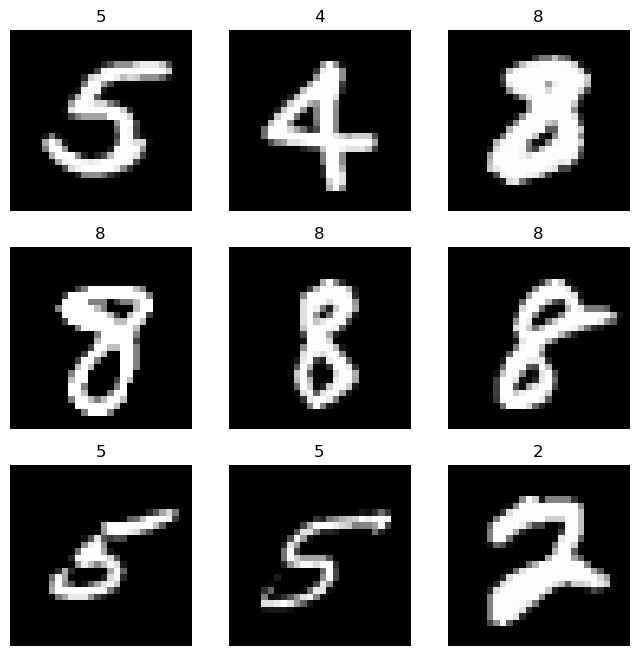

In [4]:
figure = plt.figure(figsize=(8, 8))
fils, cols = 3, 3

for i in range(1, cols * fils + 1):
    sample_idx = random.randint(0, len(train_data) - 1)
    img, label = train_data[sample_idx]

    figure.add_subplot(fils, cols, i)
    plt.title(str(label))
    plt.axis("off")
    plt.imshow(img.reshape(28, 28), cmap="gray") # Imagen
plt.show()

In [5]:
print(f'Image data type: {type(img)}')
print(f'Image size: {img.shape}')
print(f'Min and max of the image: {img.min()}, {img.max()}')
print(f'Target data type: {type(label)}')

Image data type: <class 'torch.Tensor'>
Image size: torch.Size([784])
Min and max of the image: 0.0, 1.0
Target data type: <class 'numpy.int64'>


In [6]:
print(f'Size of the train set: {len(train_data)}')
print(f'Size of the test set: {len(test_data)}')

Size of the train set: 42000
Size of the test set: 28000


In [7]:
torch.manual_seed(746278)

In [8]:
train, val = torch.utils.data.random_split(
    train_data, [0.8, 0.2]
)

print(f'Size of the train set: {len(train)}')
print(f'Size of the val set: {len(val)}')

Size of the train set: 33600
Size of the val set: 8400


## Model

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, activation_func):
        super().__init__()

        self.activation_func = activation_func
        self.hidden_size = hidden_size

        net_dict = OrderedDict([('layer0', nn.Linear(input_size, hidden_size[0]))])
        act = self.set_activation(activation_func)
        net_dict[activation_func + '0'] = act

        for i in range(1, len(hidden_size)):
            net_dict['layer' + str(i)] = nn.Linear(hidden_size[i-1], hidden_size[i])
            act = self.set_activation(activation_func)
            net_dict[activation_func + str(i)] = act
            
        net_dict['layer' + str(len(hidden_size))] = nn.Linear(hidden_size[-1], output_size)

        self.flatten = nn.Flatten()
        self.net = nn.Sequential(net_dict)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.net(x)

        return logits
    
    def set_activation(self, activation_func):
        if(activation_func == 'relu'):
            return nn.ReLU()
        elif(activation_func == 'sigmoid'):
            return nn.Sigmoid()
        elif(activation_func == 'tanh'):
            return nn.Tanh()
        else:
            return nn.ReLU()



In [10]:
device = (
    "cuda" if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device}")

Using cuda


In [11]:
model = NeuralNetwork(784, 10, [1024, 512, 256], 'tanh').to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (net): Sequential(
    (layer0): Linear(in_features=784, out_features=1024, bias=True)
    (tanh0): Tanh()
    (layer1): Linear(in_features=1024, out_features=512, bias=True)
    (tanh1): Tanh()
    (layer2): Linear(in_features=512, out_features=256, bias=True)
    (tanh2): Tanh()
    (layer3): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [12]:
total_params = sum(p.numel() for p in model.parameters())
print("Trainable parameters: ", total_params)

Trainable parameters:  1462538


In [13]:
BATCH_SIZE = 1000

train_loader = DataLoader(
    dataset=train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [14]:
# Hyperparameters
LEARNING_RATE = 0.1
EPOCHS = 20

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [16]:
# This function is executed for each iteration of the training
def train_loop(dataloader, model, loss_fn, optimizer):
    train_size = len(dataloader.dataset)
    n_batches = len(dataloader)

    # Telling pytorch that we are training
    model.train()

    train_loss, accuracy = 0, 0
    for n_batches, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward propagation
        logits = model(X.type(torch.float))

        # Backpropagation
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Accumulate loss and accuracy
        # train_loss <- train_loss + current_loss
        # accuracy <- accuracy + n_successes_current
        train_loss += loss.item()
        accuracy += (logits.argmax(1)==y).type(torch.float).sum().item()

        # Training evolution (each 10 batches)
        if n_batches % 10 == 0:
            # Number of data processed
            ndata = n_batches * BATCH_SIZE
            print(f"\tLoss: {loss.item():>7f}  [{ndata:>5d}/{train_size:>5d}]")

    # Average loss and accuracy
    train_loss /= n_batches
    accuracy /= train_size

    print(f'\tAverage accuracy/loss:')
    print(f'\t\tTraining: {(100*accuracy):>0.1f}% / {train_loss:>8f}')

In [17]:
# This function is executed for each iteration of the training
def val_loop(dataloader, model, loss_fn):
    val_size = len(dataloader.dataset)
    n_batches = len(dataloader)

    # Telling pytorch that we are evaluaiting
    model.eval()

    val_loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # Forward propagation
            logits = model(X.type(torch.float))

            # Accumulate loss and accuracy
            # val_loss <- val_loss + current_loss
            # accuracy <- accuracy + n_successes_current
            val_loss += loss_fn(logits, y).item()
            accuracy += (logits.argmax(1) == y).type(torch.float).sum().item()

    # Average loss and accuracy
    val_loss /= n_batches
    accuracy /= val_size

    print(f'\tAverage accuracy/loss:')
    print(f'\t\tValidation: {(100*accuracy):>0.1f}% / {val_loss:>8f}')

In [18]:
for t in range(EPOCHS):
    print(f"Epoch {t+1}/{EPOCHS}\n-------------------------------")
    # Train
    train_loop(train_loader, model, loss_fn, optimizer)
    # Validate
    val_loop(val_loader, model, loss_fn)
print("The model has been trained!")

Epoch 1/20
-------------------------------
	Loss: 2.301147  [    0/33600]
	Loss: 2.172864  [10000/33600]
	Loss: 1.983868  [20000/33600]
	Loss: 1.642919  [30000/33600]
	Average accuracy/loss:
		Training: 57.1% / 2.068523
	Average accuracy/loss:
		Validation: 67.9% / 1.497454
Epoch 2/20
-------------------------------
	Loss: 1.480422  [    0/33600]
	Loss: 1.144664  [10000/33600]
	Loss: 0.942724  [20000/33600]
	Loss: 0.809372  [30000/33600]
	Average accuracy/loss:
		Training: 73.6% / 1.092535
	Average accuracy/loss:
		Validation: 80.6% / 0.764022
Epoch 3/20
-------------------------------
	Loss: 0.793652  [    0/33600]
	Loss: 0.710458  [10000/33600]
	Loss: 0.618208  [20000/33600]
	Loss: 0.563966  [30000/33600]
	Average accuracy/loss:
		Training: 82.7% / 0.670915
	Average accuracy/loss:
		Validation: 85.6% / 0.557937
Epoch 4/20
-------------------------------
	Loss: 0.574267  [    0/33600]
	Loss: 0.545623  [10000/33600]
	Loss: 0.521478  [20000/33600]
	Loss: 0.475429  [30000/33600]
	Average

In [19]:
def predict(model, img):
    logits = model(img.type(torch.float).to(device))

    plt.imshow(img.cpu().reshape(28, 28), cmap="gray")
    print(logits.argmax(1).item())

8


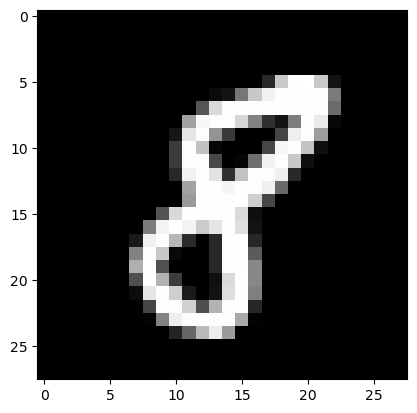

In [20]:
img = test_data[5749]
predict(model, img.unsqueeze(0))